In [110]:
import numpy as np 
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
data = pd.read_csv("SP_500_Log_Returns_19600610_19871016.csv")
data.head()

,Date,Adj Close,Log Price,Log Return
0,6/10/1960,57.970001,1.763203,-0.000225
1,6/13/1960,57.990002,1.763353,0.000150
2,6/14/1960,57.910000,1.762754,-0.000600
3,6/15/1960,57.570000,1.760196,-0.002557
4,6/16/1960,57.500000,1.759668,-0.000528


In [112]:
data.describe()

,Adj Close,Log Price,Log Return
count,6875.000000,6875.000000,6875.000000
mean,112.950846,2.020570,0.000100
std,50.516773,0.157946,0.003522
min,52.200001,1.717671,-0.030005
25%,85.865002,1.933816,-0.001755
50%,98.860001,1.995021,0.000135
75%,117.324997,2.069391,0.001962
max,336.769989,2.527333,0.021282


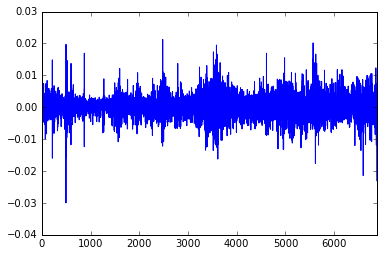

In [113]:
data["Log Return"].plot()

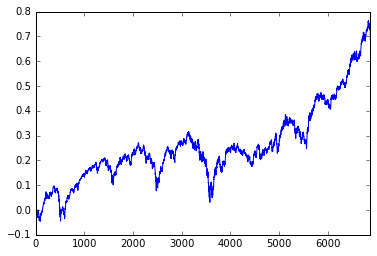

In [114]:
data["Log Return"].cumsum().plot()

In [115]:
def ValueAtRisk (data_column, alpha = 0.95):
    "This function computes the value at risk for a dataframe"
    "It should take in a Series of data "
    sorted_df = data_column.sort_values(ascending = True)
    VaR = sorted_df.quantile(q= alpha, interpolation = 'higher')
    return VaR

In [116]:
data["Log Return"] =-1000000*(np.exp(data["Log Return"])-1)


In [117]:
Var_Reg = ValueAtRisk(data["Log Return"])
Var_Reg

5636.9951825712142

In [118]:
def EWMA_mu(X, numb_initial_obs,lam = 0.97):
    """
    This function takes in a Series of returns - X 
    and generates the Exponentially Weighted Moving Average of the series. 
    It uses the initial M observations as the larger weighted term (multiplied by mu)
    """
    numb_mus = len(X)- numb_initial_obs
    mu = pd.Series(np.repeat(0.0,(numb_mus)))
    mu[0] = X[0:numb_initial_obs].mean()
    for s_delta in range(1,numb_mus):
        s = s_delta - 1 
        mu[s_delta] = lam * mu[s] + (1-lam)*X[(numb_initial_obs+s)]
        
    return mu

In [119]:
def EWMA_sig(X, numb_initial_obs,lam = 0.97):
    """
    This function takes in a Series of returns - X 
    and generates the Exponentially Weighted Moving Average of the series. 
    It uses the initial M observations as the larger weighted term (multiplied by mu)
    """
    numb_sigs = len(X)- numb_initial_obs
    sig = pd.Series(np.repeat(0.0,(numb_sigs)))
    mu[0] = X[0:numb_initial_obs].mean()
    for s_delta in range(1,numb_sigs):
        s = s_delta - 1 
        new_sig = np.power((sig[s]-X[(numb_initial_obs+s)]) , 2)
        sig[s_delta] = lam * sig[s] + (1-lam)*new_sig  
    return sig

In [120]:
mu = EWMA_mu(data["Log Return"],500)
sig = EWMA_sig(data["Log Return"],500)

In [121]:
last_element = len(mu)-1
alpha = 0.95

VaR = mu[(last_element)] + np.sqrt(sig[last_element])*norm.ppf(alpha)
VaR

inf

In [122]:
numb_days = 125
numb_block = 55
max_block_value = pd.Series(np.repeat(0.0,(numb_block-1)))
for block in range((numb_block-1)):
    start_index = block*numb_days
    end_index = (block+1)*numb_days
    max_block_value[block] = data["Log Return"][start_index:end_index].max()

count       54.000000
mean      9535.152943
std       4521.673110
min       3411.461696
25%       6642.077980
50%       8476.328643
75%      11779.782433
max      29559.282761
dtype: float64


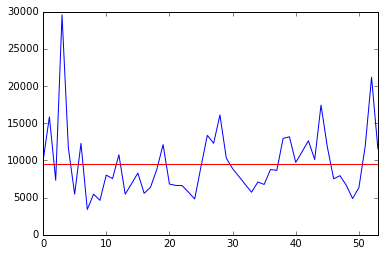

In [123]:
print(max_block_value.describe())
max_block_value.plot()
plt.axhline(y = max_block_value.mean(), color = "r")

In [124]:
from scipy.stats import genextreme
GEV_params = genextreme.fit(max_block_value )
GEV_params

(-5.1138384399677363, 3419.4476778255921, 40.845325333311877)

(array([  9.47177689e-24,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          9.47272416e-28]),
 array([  3.41146050e+03,   1.05566253e+23,   2.11132507e+23,
          3.16698760e+23,   4.22265014e+23,   5.27831267e+23,
          6.33397521e+23,   7.38963774e+23

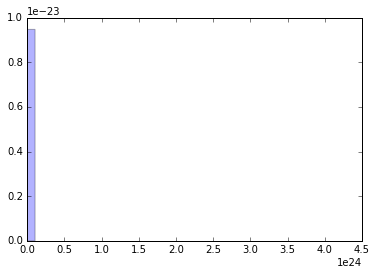

In [125]:
rv = genextreme.rvs(c = GEV_params[0], loc = GEV_params[1],  scale = GEV_params[2], size = 10000)
fig, ax = plt.subplots(1,1)
ax.hist(rv, bins=40 ,normed= True, alpha = 0.3)

In [126]:
rv1 = pd.DataFrame({'A':rv})
rv1.quantile(0.95, interpolation='higher')

A    2.528427e+07
dtype: float64

We can also solve for the VaR analytically - page 23 of the notes 

$VaR_{\alpha} = \mu - \sigma / \xi (1-(-n log(\alpha))^{-\xi}) ; \xi >0$ 

$VaR_{\alpha} = \mu - \sigma / \xi (1-(-n log(\alpha))); \xi = 0$ 


In [127]:
GEV_params[0]

-5.1138384399677363

In [128]:
GEV_params[1] - (GEV_params[2]/GEV_params[0])*(1- (np.power(-numb_days*np.log(0.95),-GEV_params[0] )))

-103505.78938507735

In [129]:
GEV_params[1] - (GEV_params[2])*(1- (-numb_days*np.log(0.95)))

3640.4887645768858

Move on to Generalized Pareto 

In [130]:
from scipy.stats import genpareto

In [131]:
GP_data1 = data[data["Log Return"]>Var_Reg]["Log Return"]
GP_params = genpareto.fit(GP_data1)
GP_params

(0.07602116124573291, 5642.2205462844549, 2007.5409499979769)

There is an analytical result for the VaR for the GP distribution as well 
from page 35 of the notes... 


$VaR_{\alpha} = u + \beta / \xi * (( (1-F(u))/(1-\alpha))^{\xi} -1)$

$u = Var_{0.95}$

$F(u) = ?$ - distribution of X = pareto?

A    11845.295434
dtype: float64

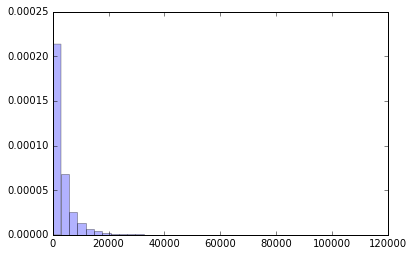

In [132]:
Scot_test = genpareto.rvs(c=0.2622, loc = 0, scale =  2549, size = 10000)
fig, ax = plt.subplots(1,1)
ax.hist(Scot_test, bins=40 ,normed= True, alpha = 0.3)

Scot_test_df = pd.DataFrame({'A':Scot_test})
Scot_test_df.quantile(0.95, interpolation='higher')

In [133]:
GP_data1.to_csv("GP_data_full.csv")
max_block_value.to_csv("max_block_value_full.csv")